# Imports

In [1]:
import os
import ipdb
import argparse
import numpy as np
import pandas as pd
import numpy.random as random
from progressbar import ProgressBar
import matplotlib.pyplot as plt
import gzip
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
import json
pd.options.display.max_columns = 9999999

In [3]:
data = []

with gzip.open('ucimessages_5_injected_G518400.json.gz', 'rt', encoding='utf-16') as f:
    for line in f:
        data.append(json.loads(line))

In [4]:
len(data)

62784

In [5]:
print(data[0])
print(data[1])
print(data[2])
print(data[3])
print(data[4])

{'t': 1082008561, 'u': '1', 'v': '2', 'is_fraud': 0, 'history_type': 'G', 'history_size': 518400, 'bip': False, 'cost': 0.0}
{'t': 1082008561, 'u': '1352', 'v': '1685', 'is_fraud': 1, 'history_type': 'G', 'history_size': 518400, 'bip': False, 'cost': 0.0}
{'t': 1082123439, 'u': '3', 'v': '4', 'is_fraud': 0, 'history_type': 'G', 'history_size': 518400, 'bip': False, 'cost': 0.0}
{'t': 1082381991, 'u': '2', 'v': '5', 'is_fraud': 0, 'history_type': 'G', 'history_size': 518400, 'bip': False, 'cost': 0.0}
{'t': 1082407219, 'u': '6', 'v': '7', 'is_fraud': 0, 'history_type': 'G', 'history_size': 518400, 'bip': False, 'cost': 0.0}


# Flatten the internal `O(1)` features

In [6]:
from utilitiesMe import flatten_dict

In [7]:
data_flattened = []
for row in data:
    data_flattened.append(flatten_dict(row))

In [8]:
data_flattened[0]

{'t': 1082008561,
 'u': '1',
 'v': '2',
 'is_fraud': 0,
 'history_type': 'G',
 'history_size': 518400,
 'bip': False,
 'cost': 0.0}

# Convert flattened json to dataframe

In [9]:
df = pd.DataFrame.from_dict(data_flattened, orient='columns')

In [10]:
df

,t,u,v,is_fraud,history_type,history_size,bip,cost,number_of_nodes,degrees_nb_one,degrees_nb_two,degrees_min,degrees_max,degrees_median,weighted_degrees_nb_one,weighted_degrees_nb_two,weighted_degrees_min,weighted_degrees_max,weighted_degrees_median,u_degree,v_degree,u_same_degree,v_same_degree,u_greater_degree,v_greater_degree,u_weighted_degree,v_weighted_degree,u_same_weighted_degree,v_same_weighted_degree,u_greater_weighted_degree,v_greater_weighted_degree,number_of_links,total_weight,link_weights_nb_one,link_weights_nb_two,link_weights_min,link_weights_max,link_weights_median,u_v_weight,u_v_same_weight,u_v_greater_weight
0,1082008561,1,2,0,G,518400,False,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1082008561,1352,1685,1,G,518400,False,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1082123439,3,4,0,G,518400,False,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1082381991,2,5,0,G,518400,False,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1082407219,6,7,0,G,518400,False,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62779,1098744248,1847,1899,0,G,518400,False,0.0,110.0,86.0,17.0,1.0,24.0,1.0,65.0,11.0,1.0,24.0,1.0,1.0,24.0,86.0,1.0,24.0,0.0,1.0,24.0,65.0,1.0,45.0,0.0,84.0,144.0,57.0,14.0,1.0,9.0,1.0,1.0,57.0,27.0
62780,1098744436,1097,1899,0,G,518400,False,0.0,110.0,87.0,16.0,1.0,25.0,1.0,65.0,12.0,1.0,25.0,1.0,1.0,25.0,87.0,1.0,23.0,0.0,1.0,25.0,65.0,1.0,45.0,0.0,84.0,144.0,57.0,14.0,1.0,9.0,1.0,1.0,57.0,27.0
62781,1098744603,1899,277,0,G,518400,False,0.0,111.0,88.0,16.0,1.0,26.0,1.0,66.0,12.0,1.0,26.0,1.0,1.0,26.0,88.0,1.0,23.0,0.0,1.0,26.0,66.0,1.0,45.0,0.0,85.0,145.0,58.0,14.0,1.0,9.0,1.0,1.0,58.0,27.0
62782,1098744711,1624,1878,0,G,518400,False,0.0,112.0,88.0,17.0,1.0,26.0,1.0,67.0,11.0,1.0,26.0,1.0,1.0,2.0,88.0,17.0,24.0,7.0,1.0,3.0,67.0,15.0,45.0,19.0,86.0,146.0,59.0,14.0,1.0,9.0,1.0,1.0,59.0,27.0


In [11]:
df.rename(columns={'t': 'timestamp'}, inplace=True)
df

,timestamp,u,v,is_fraud,history_type,history_size,bip,cost,number_of_nodes,degrees_nb_one,degrees_nb_two,degrees_min,degrees_max,degrees_median,weighted_degrees_nb_one,weighted_degrees_nb_two,weighted_degrees_min,weighted_degrees_max,weighted_degrees_median,u_degree,v_degree,u_same_degree,v_same_degree,u_greater_degree,v_greater_degree,u_weighted_degree,v_weighted_degree,u_same_weighted_degree,v_same_weighted_degree,u_greater_weighted_degree,v_greater_weighted_degree,number_of_links,total_weight,link_weights_nb_one,link_weights_nb_two,link_weights_min,link_weights_max,link_weights_median,u_v_weight,u_v_same_weight,u_v_greater_weight
0,1082008561,1,2,0,G,518400,False,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1082008561,1352,1685,1,G,518400,False,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1082123439,3,4,0,G,518400,False,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1082381991,2,5,0,G,518400,False,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1082407219,6,7,0,G,518400,False,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62779,1098744248,1847,1899,0,G,518400,False,0.0,110.0,86.0,17.0,1.0,24.0,1.0,65.0,11.0,1.0,24.0,1.0,1.0,24.0,86.0,1.0,24.0,0.0,1.0,24.0,65.0,1.0,45.0,0.0,84.0,144.0,57.0,14.0,1.0,9.0,1.0,1.0,57.0,27.0
62780,1098744436,1097,1899,0,G,518400,False,0.0,110.0,87.0,16.0,1.0,25.0,1.0,65.0,12.0,1.0,25.0,1.0,1.0,25.0,87.0,1.0,23.0,0.0,1.0,25.0,65.0,1.0,45.0,0.0,84.0,144.0,57.0,14.0,1.0,9.0,1.0,1.0,57.0,27.0
62781,1098744603,1899,277,0,G,518400,False,0.0,111.0,88.0,16.0,1.0,26.0,1.0,66.0,12.0,1.0,26.0,1.0,1.0,26.0,88.0,1.0,23.0,0.0,1.0,26.0,66.0,1.0,45.0,0.0,85.0,145.0,58.0,14.0,1.0,9.0,1.0,1.0,58.0,27.0
62782,1098744711,1624,1878,0,G,518400,False,0.0,112.0,88.0,17.0,1.0,26.0,1.0,67.0,11.0,1.0,26.0,1.0,1.0,2.0,88.0,17.0,24.0,7.0,1.0,3.0,67.0,15.0,45.0,19.0,86.0,146.0,59.0,14.0,1.0,9.0,1.0,1.0,59.0,27.0


In [12]:
df.describe()

,timestamp,is_fraud,history_size,cost,number_of_nodes,degrees_nb_one,degrees_nb_two,degrees_min,degrees_max,degrees_median,weighted_degrees_nb_one,weighted_degrees_nb_two,weighted_degrees_min,weighted_degrees_max,weighted_degrees_median,u_degree,v_degree,u_same_degree,v_same_degree,u_greater_degree,v_greater_degree,u_weighted_degree,v_weighted_degree,u_same_weighted_degree,v_same_weighted_degree,u_greater_weighted_degree,v_greater_weighted_degree,number_of_links,total_weight,link_weights_nb_one,link_weights_nb_two,link_weights_min,link_weights_max,link_weights_median,u_v_weight,u_v_same_weight,u_v_greater_weight
count,6.278400e+04,62784.000000,62784.0,62784.000000,62743.000000,62743.000000,62743.000000,62743.0,62743.000000,62743.000000,62743.000000,62743.000000,62743.0,62743.000000,62743.000000,62743.000000,62743.000000,62743.000000,62743.000000,62743.000000,62743.000000,62743.000000,62743.00000,62743.000000,62743.000000,62743.000000,62743.000000,62743.000000,62743.000000,62743.000000,62743.000000,62743.0,62743.000000,62743.000000,62743.000000,62743.000000,62743.000000
mean,1.086024e+09,0.047608,518400.0,0.000008,878.647068,379.988668,149.428319,1.0,91.030888,1.697401,333.892785,117.737851,1.0,283.935722,2.272875,6.714104,20.901758,86.118021,20.529748,193.560429,63.265209,28.316609,80.70537,41.577036,11.341616,189.011603,74.613710,1906.016034,5646.438184,994.263551,339.590456,1.0,75.428829,1.222893,6.618364,384.175095,456.550802
std,3.186740e+06,0.212936,0.0,0.000353,353.733289,118.082267,63.855979,0.0,48.644178,0.459387,115.440881,50.117373,0.0,157.227382,0.593429,6.335533,20.506366,115.817814,52.755210,171.618896,96.358407,37.985304,83.44664,88.530914,41.867153,178.451791,110.668971,1002.556919,3244.687877,505.983633,180.356400,0.0,34.998200,0.416191,11.087338,497.276816,459.263227
min,1.082009e+09,0.000000,518400.0,0.000000,43.000000,26.000000,4.000000,1.0,4.000000,1.000000,24.000000,8.000000,1.0,4.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.00000,1.000000,1.000000,0.000000,0.000000,36.000000,40.000000,34.000000,1.000000,1.0,2.000000,1.000000,1.000000,1.000000,0.000000
25%,1.083976e+09,0.000000,518400.0,0.000000,746.000000,368.000000,90.000000,1.0,57.000000,1.000000,291.000000,78.000000,1.0,166.000000,2.000000,2.000000,8.000000,15.000000,2.000000,63.000000,8.000000,5.000000,21.00000,3.000000,1.000000,54.000000,10.000000,1115.500000,2925.000000,580.000000,204.000000,1.0,41.000000,1.000000,1.000000,22.000000,67.000000
50%,1.085087e+09,0.000000,518400.0,0.000000,1005.000000,430.000000,172.000000,1.0,81.000000,2.000000,390.000000,134.000000,1.0,255.000000,2.000000,5.000000,16.000000,37.000000,5.000000,139.000000,28.000000,14.000000,55.00000,8.000000,2.000000,129.000000,33.000000,2162.000000,6200.000000,1160.000000,387.000000,1.0,73.000000,1.000000,3.000000,131.000000,286.000000
75%,1.086349e+09,0.000000,518400.0,0.000000,1162.000000,456.000000,198.000000,1.0,125.000000,2.000000,414.000000,158.000000,1.0,394.000000,3.000000,9.000000,27.000000,107.000000,15.000000,276.000000,75.000000,37.000000,116.00000,27.000000,5.000000,272.000000,92.000000,2779.000000,8547.500000,1414.000000,483.000000,1.0,107.000000,1.000000,7.000000,552.000000,725.000000
max,1.098745e+09,1.000000,518400.0,0.015625,1313.000000,507.000000,246.000000,1.0,194.000000,2.000000,462.000000,200.000000,1.0,634.000000,3.000000,100.000000,194.000000,506.000000,503.000000,829.000000,826.000000,620.000000,634.00000,461.000000,459.000000,873.000000,867.000000,3209.000000,10535.000000,1734.000000,606.000000,1.0,125.000000,2.000000,125.000000,1733.000000,1642.000000


# Remove NaNs

In [13]:
df.head(10)

,timestamp,u,v,is_fraud,history_type,history_size,bip,cost,number_of_nodes,degrees_nb_one,degrees_nb_two,degrees_min,degrees_max,degrees_median,weighted_degrees_nb_one,weighted_degrees_nb_two,weighted_degrees_min,weighted_degrees_max,weighted_degrees_median,u_degree,v_degree,u_same_degree,v_same_degree,u_greater_degree,v_greater_degree,u_weighted_degree,v_weighted_degree,u_same_weighted_degree,v_same_weighted_degree,u_greater_weighted_degree,v_greater_weighted_degree,number_of_links,total_weight,link_weights_nb_one,link_weights_nb_two,link_weights_min,link_weights_max,link_weights_median,u_v_weight,u_v_same_weight,u_v_greater_weight
0,1082008561,1,2,0,G,518400,False,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1082008561,1352,1685,1,G,518400,False,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1082123439,3,4,0,G,518400,False,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1082381991,2,5,0,G,518400,False,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1082407219,6,7,0,G,518400,False,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,1082407356,7,8,0,G,518400,False,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,1082408003,10,9,0,G,518400,False,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,1082408053,11,9,0,G,518400,False,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,1082408788,12,13,0,G,518400,False,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,1082409354,14,9,0,G,518400,False,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
# Create a new DataFrame to preserve rows with NaN
nan_df = pd.DataFrame(columns=df.columns)

# Remove rows with NaN from 'df' and append them to 'nan_df'
nan_rows = df[df.isnull().any(axis=1)]
df = df.dropna()
nan_df = nan_df.append(nan_rows)

# Display the updated 'df' and 'nan_df'
print("Updated DataFrame without NaN:")
df

Updated DataFrame without NaN:


,timestamp,u,v,is_fraud,history_type,history_size,bip,cost,number_of_nodes,degrees_nb_one,degrees_nb_two,degrees_min,degrees_max,degrees_median,weighted_degrees_nb_one,weighted_degrees_nb_two,weighted_degrees_min,weighted_degrees_max,weighted_degrees_median,u_degree,v_degree,u_same_degree,v_same_degree,u_greater_degree,v_greater_degree,u_weighted_degree,v_weighted_degree,u_same_weighted_degree,v_same_weighted_degree,u_greater_weighted_degree,v_greater_weighted_degree,number_of_links,total_weight,link_weights_nb_one,link_weights_nb_two,link_weights_min,link_weights_max,link_weights_median,u_v_weight,u_v_same_weight,u_v_greater_weight
41,1082541811,41,42,0,G,518400,False,0.0,43.0,26.0,14.0,1.0,9.0,1.0,24.0,13.0,1.0,10.0,1.0,1.0,6.0,26.0,1.0,17.0,1.0,1.0,6.0,24.0,1.0,19.0,1.0,36.0,40.0,34.0,1.0,1.0,4.0,1.0,1.0,34.0,2.0
42,1082543944,41,43,0,G,518400,False,0.0,44.0,27.0,14.0,1.0,9.0,1.0,25.0,13.0,1.0,10.0,1.0,1.0,7.0,27.0,1.0,17.0,1.0,1.0,7.0,25.0,1.0,19.0,1.0,37.0,41.0,35.0,1.0,1.0,4.0,1.0,1.0,35.0,2.0
43,1082551300,40,9,0,G,518400,False,0.0,44.0,26.0,15.0,1.0,10.0,1.0,24.0,14.0,1.0,11.0,1.0,2.0,10.0,15.0,1.0,3.0,0.0,2.0,11.0,14.0,1.0,6.0,0.0,38.0,42.0,36.0,1.0,1.0,4.0,1.0,1.0,36.0,2.0
44,1082553068,44,45,0,G,518400,False,0.0,46.0,28.0,15.0,1.0,10.0,1.0,26.0,14.0,1.0,11.0,1.0,1.0,1.0,28.0,28.0,18.0,18.0,1.0,1.0,26.0,26.0,20.0,20.0,39.0,43.0,37.0,1.0,1.0,4.0,1.0,1.0,37.0,2.0
45,1082555305,22,46,0,G,518400,False,0.0,47.0,29.0,14.0,1.0,10.0,1.0,27.0,13.0,1.0,11.0,1.0,1.0,3.0,29.0,2.0,18.0,2.0,1.0,3.0,27.0,3.0,20.0,4.0,40.0,44.0,38.0,1.0,1.0,4.0,1.0,1.0,38.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62779,1098744248,1847,1899,0,G,518400,False,0.0,110.0,86.0,17.0,1.0,24.0,1.0,65.0,11.0,1.0,24.0,1.0,1.0,24.0,86.0,1.0,24.0,0.0,1.0,24.0,65.0,1.0,45.0,0.0,84.0,144.0,57.0,14.0,1.0,9.0,1.0,1.0,57.0,27.0
62780,1098744436,1097,1899,0,G,518400,False,0.0,110.0,87.0,16.0,1.0,25.0,1.0,65.0,12.0,1.0,25.0,1.0,1.0,25.0,87.0,1.0,23.0,0.0,1.0,25.0,65.0,1.0,45.0,0.0,84.0,144.0,57.0,14.0,1.0,9.0,1.0,1.0,57.0,27.0
62781,1098744603,1899,277,0,G,518400,False,0.0,111.0,88.0,16.0,1.0,26.0,1.0,66.0,12.0,1.0,26.0,1.0,1.0,26.0,88.0,1.0,23.0,0.0,1.0,26.0,66.0,1.0,45.0,0.0,85.0,145.0,58.0,14.0,1.0,9.0,1.0,1.0,58.0,27.0
62782,1098744711,1624,1878,0,G,518400,False,0.0,112.0,88.0,17.0,1.0,26.0,1.0,67.0,11.0,1.0,26.0,1.0,1.0,2.0,88.0,17.0,24.0,7.0,1.0,3.0,67.0,15.0,45.0,19.0,86.0,146.0,59.0,14.0,1.0,9.0,1.0,1.0,59.0,27.0


In [15]:
nan_df

,timestamp,u,v,is_fraud,history_type,history_size,bip,cost,number_of_nodes,degrees_nb_one,degrees_nb_two,degrees_min,degrees_max,degrees_median,weighted_degrees_nb_one,weighted_degrees_nb_two,weighted_degrees_min,weighted_degrees_max,weighted_degrees_median,u_degree,v_degree,u_same_degree,v_same_degree,u_greater_degree,v_greater_degree,u_weighted_degree,v_weighted_degree,u_same_weighted_degree,v_same_weighted_degree,u_greater_weighted_degree,v_greater_weighted_degree,number_of_links,total_weight,link_weights_nb_one,link_weights_nb_two,link_weights_min,link_weights_max,link_weights_median,u_v_weight,u_v_same_weight,u_v_greater_weight
0,1082008561,1,2,0,G,518400,False,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1082008561,1352,1685,1,G,518400,False,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1082123439,3,4,0,G,518400,False,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1082381991,2,5,0,G,518400,False,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1082407219,6,7,0,G,518400,False,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,1082407356,7,8,0,G,518400,False,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,1082408003,10,9,0,G,518400,False,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,1082408053,11,9,0,G,518400,False,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,1082408788,12,13,0,G,518400,False,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,1082409354,14,9,0,G,518400,False,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
df.describe()

,timestamp,is_fraud,history_size,cost,number_of_nodes,degrees_nb_one,degrees_nb_two,degrees_min,degrees_max,degrees_median,weighted_degrees_nb_one,weighted_degrees_nb_two,weighted_degrees_min,weighted_degrees_max,weighted_degrees_median,u_degree,v_degree,u_same_degree,v_same_degree,u_greater_degree,v_greater_degree,u_weighted_degree,v_weighted_degree,u_same_weighted_degree,v_same_weighted_degree,u_greater_weighted_degree,v_greater_weighted_degree,number_of_links,total_weight,link_weights_nb_one,link_weights_nb_two,link_weights_min,link_weights_max,link_weights_median,u_v_weight,u_v_same_weight,u_v_greater_weight
count,6.274300e+04,62743.000000,62743.0,62743.000000,62743.000000,62743.000000,62743.000000,62743.0,62743.000000,62743.000000,62743.000000,62743.000000,62743.0,62743.000000,62743.000000,62743.000000,62743.000000,62743.000000,62743.000000,62743.000000,62743.000000,62743.000000,62743.00000,62743.000000,62743.000000,62743.000000,62743.000000,62743.000000,62743.000000,62743.000000,62743.000000,62743.0,62743.000000,62743.000000,62743.000000,62743.000000,62743.000000
mean,1.086026e+09,0.047607,518400.0,0.000008,878.647068,379.988668,149.428319,1.0,91.030888,1.697401,333.892785,117.737851,1.0,283.935722,2.272875,6.714104,20.901758,86.118021,20.529748,193.560429,63.265209,28.316609,80.70537,41.577036,11.341616,189.011603,74.613710,1906.016034,5646.438184,994.263551,339.590456,1.0,75.428829,1.222893,6.618364,384.175095,456.550802
std,3.186449e+06,0.212935,0.0,0.000353,353.733289,118.082267,63.855979,0.0,48.644178,0.459387,115.440881,50.117373,0.0,157.227382,0.593429,6.335533,20.506366,115.817814,52.755210,171.618896,96.358407,37.985304,83.44664,88.530914,41.867153,178.451791,110.668971,1002.556919,3244.687877,505.983633,180.356400,0.0,34.998200,0.416191,11.087338,497.276816,459.263227
min,1.082542e+09,0.000000,518400.0,0.000000,43.000000,26.000000,4.000000,1.0,4.000000,1.000000,24.000000,8.000000,1.0,4.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.00000,1.000000,1.000000,0.000000,0.000000,36.000000,40.000000,34.000000,1.000000,1.0,2.000000,1.000000,1.000000,1.000000,0.000000
25%,1.083977e+09,0.000000,518400.0,0.000000,746.000000,368.000000,90.000000,1.0,57.000000,1.000000,291.000000,78.000000,1.0,166.000000,2.000000,2.000000,8.000000,15.000000,2.000000,63.000000,8.000000,5.000000,21.00000,3.000000,1.000000,54.000000,10.000000,1115.500000,2925.000000,580.000000,204.000000,1.0,41.000000,1.000000,1.000000,22.000000,67.000000
50%,1.085087e+09,0.000000,518400.0,0.000000,1005.000000,430.000000,172.000000,1.0,81.000000,2.000000,390.000000,134.000000,1.0,255.000000,2.000000,5.000000,16.000000,37.000000,5.000000,139.000000,28.000000,14.000000,55.00000,8.000000,2.000000,129.000000,33.000000,2162.000000,6200.000000,1160.000000,387.000000,1.0,73.000000,1.000000,3.000000,131.000000,286.000000
75%,1.086353e+09,0.000000,518400.0,0.000000,1162.000000,456.000000,198.000000,1.0,125.000000,2.000000,414.000000,158.000000,1.0,394.000000,3.000000,9.000000,27.000000,107.000000,15.000000,276.000000,75.000000,37.000000,116.00000,27.000000,5.000000,272.000000,92.000000,2779.000000,8547.500000,1414.000000,483.000000,1.0,107.000000,1.000000,7.000000,552.000000,725.000000
max,1.098745e+09,1.000000,518400.0,0.015625,1313.000000,507.000000,246.000000,1.0,194.000000,2.000000,462.000000,200.000000,1.0,634.000000,3.000000,100.000000,194.000000,506.000000,503.000000,829.000000,826.000000,620.000000,634.00000,461.000000,459.000000,873.000000,867.000000,3209.000000,10535.000000,1734.000000,606.000000,1.0,125.000000,2.000000,125.000000,1733.000000,1642.000000


In [17]:
df_features = df.drop(["timestamp",
                       "u",
                       "v", 
                        "history_type", 
                        "bip", 
                        "cost", # cost of O1 features
                        "history_size"], axis="columns")
df_features

,is_fraud,number_of_nodes,degrees_nb_one,degrees_nb_two,degrees_min,degrees_max,degrees_median,weighted_degrees_nb_one,weighted_degrees_nb_two,weighted_degrees_min,weighted_degrees_max,weighted_degrees_median,u_degree,v_degree,u_same_degree,v_same_degree,u_greater_degree,v_greater_degree,u_weighted_degree,v_weighted_degree,u_same_weighted_degree,v_same_weighted_degree,u_greater_weighted_degree,v_greater_weighted_degree,number_of_links,total_weight,link_weights_nb_one,link_weights_nb_two,link_weights_min,link_weights_max,link_weights_median,u_v_weight,u_v_same_weight,u_v_greater_weight
41,0,43.0,26.0,14.0,1.0,9.0,1.0,24.0,13.0,1.0,10.0,1.0,1.0,6.0,26.0,1.0,17.0,1.0,1.0,6.0,24.0,1.0,19.0,1.0,36.0,40.0,34.0,1.0,1.0,4.0,1.0,1.0,34.0,2.0
42,0,44.0,27.0,14.0,1.0,9.0,1.0,25.0,13.0,1.0,10.0,1.0,1.0,7.0,27.0,1.0,17.0,1.0,1.0,7.0,25.0,1.0,19.0,1.0,37.0,41.0,35.0,1.0,1.0,4.0,1.0,1.0,35.0,2.0
43,0,44.0,26.0,15.0,1.0,10.0,1.0,24.0,14.0,1.0,11.0,1.0,2.0,10.0,15.0,1.0,3.0,0.0,2.0,11.0,14.0,1.0,6.0,0.0,38.0,42.0,36.0,1.0,1.0,4.0,1.0,1.0,36.0,2.0
44,0,46.0,28.0,15.0,1.0,10.0,1.0,26.0,14.0,1.0,11.0,1.0,1.0,1.0,28.0,28.0,18.0,18.0,1.0,1.0,26.0,26.0,20.0,20.0,39.0,43.0,37.0,1.0,1.0,4.0,1.0,1.0,37.0,2.0
45,0,47.0,29.0,14.0,1.0,10.0,1.0,27.0,13.0,1.0,11.0,1.0,1.0,3.0,29.0,2.0,18.0,2.0,1.0,3.0,27.0,3.0,20.0,4.0,40.0,44.0,38.0,1.0,1.0,4.0,1.0,1.0,38.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62779,0,110.0,86.0,17.0,1.0,24.0,1.0,65.0,11.0,1.0,24.0,1.0,1.0,24.0,86.0,1.0,24.0,0.0,1.0,24.0,65.0,1.0,45.0,0.0,84.0,144.0,57.0,14.0,1.0,9.0,1.0,1.0,57.0,27.0
62780,0,110.0,87.0,16.0,1.0,25.0,1.0,65.0,12.0,1.0,25.0,1.0,1.0,25.0,87.0,1.0,23.0,0.0,1.0,25.0,65.0,1.0,45.0,0.0,84.0,144.0,57.0,14.0,1.0,9.0,1.0,1.0,57.0,27.0
62781,0,111.0,88.0,16.0,1.0,26.0,1.0,66.0,12.0,1.0,26.0,1.0,1.0,26.0,88.0,1.0,23.0,0.0,1.0,26.0,66.0,1.0,45.0,0.0,85.0,145.0,58.0,14.0,1.0,9.0,1.0,1.0,58.0,27.0
62782,0,112.0,88.0,17.0,1.0,26.0,1.0,67.0,11.0,1.0,26.0,1.0,1.0,2.0,88.0,17.0,24.0,7.0,1.0,3.0,67.0,15.0,45.0,19.0,86.0,146.0,59.0,14.0,1.0,9.0,1.0,1.0,59.0,27.0


In [18]:
df_features.describe()

,is_fraud,number_of_nodes,degrees_nb_one,degrees_nb_two,degrees_min,degrees_max,degrees_median,weighted_degrees_nb_one,weighted_degrees_nb_two,weighted_degrees_min,weighted_degrees_max,weighted_degrees_median,u_degree,v_degree,u_same_degree,v_same_degree,u_greater_degree,v_greater_degree,u_weighted_degree,v_weighted_degree,u_same_weighted_degree,v_same_weighted_degree,u_greater_weighted_degree,v_greater_weighted_degree,number_of_links,total_weight,link_weights_nb_one,link_weights_nb_two,link_weights_min,link_weights_max,link_weights_median,u_v_weight,u_v_same_weight,u_v_greater_weight
count,62743.000000,62743.000000,62743.000000,62743.000000,62743.0,62743.000000,62743.000000,62743.000000,62743.000000,62743.0,62743.000000,62743.000000,62743.000000,62743.000000,62743.000000,62743.000000,62743.000000,62743.000000,62743.000000,62743.00000,62743.000000,62743.000000,62743.000000,62743.000000,62743.000000,62743.000000,62743.000000,62743.000000,62743.0,62743.000000,62743.000000,62743.000000,62743.000000,62743.000000
mean,0.047607,878.647068,379.988668,149.428319,1.0,91.030888,1.697401,333.892785,117.737851,1.0,283.935722,2.272875,6.714104,20.901758,86.118021,20.529748,193.560429,63.265209,28.316609,80.70537,41.577036,11.341616,189.011603,74.613710,1906.016034,5646.438184,994.263551,339.590456,1.0,75.428829,1.222893,6.618364,384.175095,456.550802
std,0.212935,353.733289,118.082267,63.855979,0.0,48.644178,0.459387,115.440881,50.117373,0.0,157.227382,0.593429,6.335533,20.506366,115.817814,52.755210,171.618896,96.358407,37.985304,83.44664,88.530914,41.867153,178.451791,110.668971,1002.556919,3244.687877,505.983633,180.356400,0.0,34.998200,0.416191,11.087338,497.276816,459.263227
min,0.000000,43.000000,26.000000,4.000000,1.0,4.000000,1.000000,24.000000,8.000000,1.0,4.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.00000,1.000000,1.000000,0.000000,0.000000,36.000000,40.000000,34.000000,1.000000,1.0,2.000000,1.000000,1.000000,1.000000,0.000000
25%,0.000000,746.000000,368.000000,90.000000,1.0,57.000000,1.000000,291.000000,78.000000,1.0,166.000000,2.000000,2.000000,8.000000,15.000000,2.000000,63.000000,8.000000,5.000000,21.00000,3.000000,1.000000,54.000000,10.000000,1115.500000,2925.000000,580.000000,204.000000,1.0,41.000000,1.000000,1.000000,22.000000,67.000000
50%,0.000000,1005.000000,430.000000,172.000000,1.0,81.000000,2.000000,390.000000,134.000000,1.0,255.000000,2.000000,5.000000,16.000000,37.000000,5.000000,139.000000,28.000000,14.000000,55.00000,8.000000,2.000000,129.000000,33.000000,2162.000000,6200.000000,1160.000000,387.000000,1.0,73.000000,1.000000,3.000000,131.000000,286.000000
75%,0.000000,1162.000000,456.000000,198.000000,1.0,125.000000,2.000000,414.000000,158.000000,1.0,394.000000,3.000000,9.000000,27.000000,107.000000,15.000000,276.000000,75.000000,37.000000,116.00000,27.000000,5.000000,272.000000,92.000000,2779.000000,8547.500000,1414.000000,483.000000,1.0,107.000000,1.000000,7.000000,552.000000,725.000000
max,1.000000,1313.000000,507.000000,246.000000,1.0,194.000000,2.000000,462.000000,200.000000,1.0,634.000000,3.000000,100.000000,194.000000,506.000000,503.000000,829.000000,826.000000,620.000000,634.00000,461.000000,459.000000,873.000000,867.000000,3209.000000,10535.000000,1734.000000,606.000000,1.0,125.000000,2.000000,125.000000,1733.000000,1642.000000


In [19]:
df_target = df["is_fraud"]
df_target

41       0
42       0
43       0
44       0
45       0
        ..
62779    0
62780    0
62781    0
62782    0
62783    0
Name: is_fraud, Length: 62743, dtype: int64

# Learning Technique #2: Classical + Underasmpling in training only

## $r$ = 0.7
Before undersampling, take 30% for testing then the 70% take it for training and do undersampling on it

In [20]:
percentage=round(len(df)/100*70) 
train_df=df_features.head(percentage)
test_df=df_features.iloc[percentage:len(df_features),:]

In [21]:
len(train_df) + len(test_df) == len(df)

True

In [22]:
train_df

,is_fraud,number_of_nodes,degrees_nb_one,degrees_nb_two,degrees_min,degrees_max,degrees_median,weighted_degrees_nb_one,weighted_degrees_nb_two,weighted_degrees_min,weighted_degrees_max,weighted_degrees_median,u_degree,v_degree,u_same_degree,v_same_degree,u_greater_degree,v_greater_degree,u_weighted_degree,v_weighted_degree,u_same_weighted_degree,v_same_weighted_degree,u_greater_weighted_degree,v_greater_weighted_degree,number_of_links,total_weight,link_weights_nb_one,link_weights_nb_two,link_weights_min,link_weights_max,link_weights_median,u_v_weight,u_v_same_weight,u_v_greater_weight
41,0,43.0,26.0,14.0,1.0,9.0,1.0,24.0,13.0,1.0,10.0,1.0,1.0,6.0,26.0,1.0,17.0,1.0,1.0,6.0,24.0,1.0,19.0,1.0,36.0,40.0,34.0,1.0,1.0,4.0,1.0,1.0,34.0,2.0
42,0,44.0,27.0,14.0,1.0,9.0,1.0,25.0,13.0,1.0,10.0,1.0,1.0,7.0,27.0,1.0,17.0,1.0,1.0,7.0,25.0,1.0,19.0,1.0,37.0,41.0,35.0,1.0,1.0,4.0,1.0,1.0,35.0,2.0
43,0,44.0,26.0,15.0,1.0,10.0,1.0,24.0,14.0,1.0,11.0,1.0,2.0,10.0,15.0,1.0,3.0,0.0,2.0,11.0,14.0,1.0,6.0,0.0,38.0,42.0,36.0,1.0,1.0,4.0,1.0,1.0,36.0,2.0
44,0,46.0,28.0,15.0,1.0,10.0,1.0,26.0,14.0,1.0,11.0,1.0,1.0,1.0,28.0,28.0,18.0,18.0,1.0,1.0,26.0,26.0,20.0,20.0,39.0,43.0,37.0,1.0,1.0,4.0,1.0,1.0,37.0,2.0
45,0,47.0,29.0,14.0,1.0,10.0,1.0,27.0,13.0,1.0,11.0,1.0,1.0,3.0,29.0,2.0,18.0,2.0,1.0,3.0,27.0,3.0,20.0,4.0,40.0,44.0,38.0,1.0,1.0,4.0,1.0,1.0,38.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43956,0,1277.0,466.0,216.0,1.0,145.0,2.0,426.0,152.0,1.0,414.0,3.0,4.0,95.0,98.0,1.0,384.0,1.0,8.0,414.0,37.0,1.0,413.0,0.0,3096.0,9689.0,1565.0,586.0,1.0,95.0,1.0,1.0,1565.0,1531.0
43957,0,1276.0,468.0,213.0,1.0,145.0,2.0,428.0,149.0,1.0,414.0,3.0,7.0,11.0,43.0,14.0,222.0,130.0,20.0,41.0,11.0,7.0,238.0,110.0,3093.0,9673.0,1566.0,584.0,1.0,95.0,1.0,7.0,71.0,251.0
43958,0,1276.0,468.0,213.0,1.0,145.0,2.0,428.0,149.0,1.0,414.0,3.0,11.0,13.0,16.0,17.0,129.0,93.0,13.0,40.0,17.0,7.0,315.0,117.0,3093.0,9672.0,1566.0,584.0,1.0,95.0,1.0,1.0,1566.0,1527.0
43959,1,1277.0,468.0,214.0,1.0,145.0,2.0,428.0,150.0,1.0,414.0,3.0,1.0,2.0,468.0,214.0,809.0,595.0,1.0,2.0,428.0,150.0,849.0,699.0,3094.0,9673.0,1567.0,584.0,1.0,95.0,1.0,1.0,1567.0,1527.0


In [23]:
test_df

,is_fraud,number_of_nodes,degrees_nb_one,degrees_nb_two,degrees_min,degrees_max,degrees_median,weighted_degrees_nb_one,weighted_degrees_nb_two,weighted_degrees_min,weighted_degrees_max,weighted_degrees_median,u_degree,v_degree,u_same_degree,v_same_degree,u_greater_degree,v_greater_degree,u_weighted_degree,v_weighted_degree,u_same_weighted_degree,v_same_weighted_degree,u_greater_weighted_degree,v_greater_weighted_degree,number_of_links,total_weight,link_weights_nb_one,link_weights_nb_two,link_weights_min,link_weights_max,link_weights_median,u_v_weight,u_v_same_weight,u_v_greater_weight
43961,0,1276.0,467.0,215.0,1.0,145.0,2.0,427.0,151.0,1.0,415.0,3.0,10.0,95.0,24.0,1.0,145.0,1.0,20.0,415.0,12.0,1.0,238.0,0.0,3089.0,9668.0,1562.0,584.0,1.0,95.0,1.0,2.0,584.0,943.0
43962,0,1276.0,467.0,215.0,1.0,145.0,2.0,427.0,151.0,1.0,415.0,3.0,2.0,14.0,215.0,15.0,594.0,77.0,4.0,35.0,57.0,7.0,553.0,138.0,3087.0,9665.0,1561.0,583.0,1.0,95.0,1.0,3.0,284.0,659.0
43963,0,1275.0,467.0,214.0,1.0,145.0,2.0,427.0,150.0,1.0,415.0,3.0,7.0,13.0,43.0,17.0,221.0,92.0,30.0,53.0,6.0,2.0,165.0,87.0,3085.0,9663.0,1559.0,584.0,1.0,95.0,1.0,5.0,127.0,393.0
43964,0,1275.0,467.0,214.0,1.0,145.0,2.0,427.0,150.0,1.0,415.0,3.0,2.0,14.0,214.0,15.0,594.0,77.0,4.0,64.0,58.0,1.0,553.0,68.0,3084.0,9660.0,1558.0,584.0,1.0,95.0,1.0,2.0,584.0,942.0
43965,0,1275.0,468.0,215.0,1.0,145.0,2.0,427.0,151.0,1.0,415.0,3.0,8.0,10.0,26.0,23.0,195.0,145.0,16.0,53.0,4.0,3.0,284.0,87.0,3079.0,9650.0,1555.0,584.0,1.0,95.0,1.0,4.0,139.0,519.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62779,0,110.0,86.0,17.0,1.0,24.0,1.0,65.0,11.0,1.0,24.0,1.0,1.0,24.0,86.0,1.0,24.0,0.0,1.0,24.0,65.0,1.0,45.0,0.0,84.0,144.0,57.0,14.0,1.0,9.0,1.0,1.0,57.0,27.0
62780,0,110.0,87.0,16.0,1.0,25.0,1.0,65.0,12.0,1.0,25.0,1.0,1.0,25.0,87.0,1.0,23.0,0.0,1.0,25.0,65.0,1.0,45.0,0.0,84.0,144.0,57.0,14.0,1.0,9.0,1.0,1.0,57.0,27.0
62781,0,111.0,88.0,16.0,1.0,26.0,1.0,66.0,12.0,1.0,26.0,1.0,1.0,26.0,88.0,1.0,23.0,0.0,1.0,26.0,66.0,1.0,45.0,0.0,85.0,145.0,58.0,14.0,1.0,9.0,1.0,1.0,58.0,27.0
62782,0,112.0,88.0,17.0,1.0,26.0,1.0,67.0,11.0,1.0,26.0,1.0,1.0,2.0,88.0,17.0,24.0,7.0,1.0,3.0,67.0,15.0,45.0,19.0,86.0,146.0,59.0,14.0,1.0,9.0,1.0,1.0,59.0,27.0


### Undersampling and training on `X_train, y_train`

In [24]:
train_df["is_fraud"].value_counts()

0    41815
1     2105
Name: is_fraud, dtype: int64

In [25]:
# Separating the data for analysis (they will be Series)
nonanomalous = train_df[train_df.is_fraud == 0]
anomalous = train_df[train_df.is_fraud == 1]

In [26]:
print(len(nonanomalous))
print(len(anomalous))

41815
2105


In [27]:
print(nonanomalous.shape)
print(anomalous.shape)

(41815, 34)
(2105, 34)


In [28]:
# Compare the values for both classes
train_df.groupby("is_fraud").mean()

,number_of_nodes,degrees_nb_one,degrees_nb_two,degrees_min,degrees_max,degrees_median,weighted_degrees_nb_one,weighted_degrees_nb_two,weighted_degrees_min,weighted_degrees_max,weighted_degrees_median,u_degree,v_degree,u_same_degree,v_same_degree,u_greater_degree,v_greater_degree,u_weighted_degree,v_weighted_degree,u_same_weighted_degree,v_same_weighted_degree,u_greater_weighted_degree,v_greater_weighted_degree,number_of_links,total_weight,link_weights_nb_one,link_weights_nb_two,link_weights_min,link_weights_max,link_weights_median,u_v_weight,u_v_same_weight,u_v_greater_weight
is_fraud,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1024.014325,427.790434,170.712304,1.0,110.899486,1.839340,388.081621,137.243382,1.0,343.90348,2.340643,8.540691,25.818438,64.721177,10.473873,204.742222,57.786201,36.515987,101.548129,27.269401,4.118379,192.979696,66.482841,2385.673227,7200.448452,1240.439483,419.380509,1.0,91.186703,1.252302,7.369413,427.898912,538.241994
1,1020.616152,428.444181,168.982423,1.0,110.393349,1.826128,388.605701,136.073634,1.0,340.67791,2.339192,1.601900,5.344418,336.561520,158.943468,517.087886,332.968171,2.176247,14.187173,297.583848,129.723990,564.558195,382.021853,2365.884086,7124.213302,1230.326841,416.359620,1.0,90.413777,1.254632,1.002375,1229.404276,1134.956770


In [29]:
# Sampling
nonanomalous_sample = nonanomalous.sample(n = len(anomalous), random_state=12)

In [30]:
# Concatenating
new_dataset = pd.concat([nonanomalous_sample, anomalous], axis=0)

In [31]:
new_dataset

,is_fraud,number_of_nodes,degrees_nb_one,degrees_nb_two,degrees_min,degrees_max,degrees_median,weighted_degrees_nb_one,weighted_degrees_nb_two,weighted_degrees_min,weighted_degrees_max,weighted_degrees_median,u_degree,v_degree,u_same_degree,v_same_degree,u_greater_degree,v_greater_degree,u_weighted_degree,v_weighted_degree,u_same_weighted_degree,v_same_weighted_degree,u_greater_weighted_degree,v_greater_weighted_degree,number_of_links,total_weight,link_weights_nb_one,link_weights_nb_two,link_weights_min,link_weights_max,link_weights_median,u_v_weight,u_v_same_weight,u_v_greater_weight
36186,0,1177.0,474.0,180.0,1.0,118.0,2.0,425.0,121.0,1.0,554.0,3.0,3.0,5.0,107.0,55.0,416.0,276.0,10.0,22.0,16.0,7.0,336.0,202.0,2761.0,8513.0,1353.0,558.0,1.0,103.0,2.0,4.0,152.0,457.0
2556,0,513.0,274.0,72.0,1.0,53.0,1.0,258.0,52.0,1.0,142.0,1.0,4.0,17.0,28.0,4.0,103.0,16.0,6.0,65.0,11.0,1.0,131.0,16.0,965.0,2460.0,569.0,158.0,1.0,40.0,1.0,1.0,569.0,396.0
37098,0,1206.0,466.0,201.0,1.0,125.0,2.0,416.0,148.0,1.0,550.0,3.0,5.0,6.0,54.0,46.0,281.0,235.0,72.0,59.0,3.0,4.0,50.0,63.0,2821.0,8608.0,1404.0,566.0,1.0,100.0,2.0,52.0,1.0,6.0
16209,0,1166.0,459.0,210.0,1.0,188.0,2.0,421.0,176.0,1.0,385.0,2.0,5.0,14.0,55.0,15.0,291.0,109.0,22.0,44.0,7.0,4.0,205.0,120.0,3137.0,9598.0,1695.0,483.0,1.0,93.0,1.0,13.0,12.0,106.0
7777,0,857.0,425.0,124.0,1.0,84.0,2.0,396.0,101.0,1.0,210.0,2.0,14.0,33.0,9.0,2.0,59.0,8.0,56.0,72.0,2.0,1.0,53.0,44.0,1845.0,5472.0,1005.0,327.0,1.0,95.0,1.0,2.0,327.0,513.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43861,1,1288.0,464.0,227.0,1.0,145.0,2.0,428.0,159.0,1.0,413.0,3.0,1.0,2.0,464.0,227.0,824.0,597.0,1.0,2.0,428.0,159.0,860.0,701.0,3132.0,9840.0,1584.0,578.0,1.0,95.0,1.0,1.0,1584.0,1548.0
43930,1,1282.0,468.0,218.0,1.0,145.0,2.0,428.0,156.0,1.0,413.0,3.0,1.0,2.0,468.0,218.0,814.0,596.0,1.0,2.0,428.0,156.0,854.0,698.0,3112.0,9739.0,1573.0,585.0,1.0,95.0,1.0,1.0,1573.0,1539.0
43952,1,1280.0,468.0,217.0,1.0,145.0,2.0,428.0,153.0,1.0,412.0,3.0,1.0,7.0,468.0,43.0,812.0,222.0,1.0,26.0,428.0,12.0,852.0,190.0,3096.0,9697.0,1563.0,588.0,1.0,95.0,1.0,1.0,1563.0,1533.0
43953,1,1280.0,467.0,218.0,1.0,145.0,2.0,427.0,154.0,1.0,412.0,3.0,2.0,9.0,218.0,27.0,595.0,168.0,2.0,11.0,154.0,25.0,699.0,346.0,3097.0,9698.0,1564.0,588.0,1.0,95.0,1.0,1.0,1564.0,1533.0


Author: Now the rows of the `nonanomalous` are random

In [32]:
# Now we will check deeper the values on the new dataset and compare them
new_dataset["is_fraud"].value_counts()

0    2105
1    2105
Name: is_fraud, dtype: int64

In [33]:
new_dataset.groupby("is_fraud").mean()

,number_of_nodes,degrees_nb_one,degrees_nb_two,degrees_min,degrees_max,degrees_median,weighted_degrees_nb_one,weighted_degrees_nb_two,weighted_degrees_min,weighted_degrees_max,weighted_degrees_median,u_degree,v_degree,u_same_degree,v_same_degree,u_greater_degree,v_greater_degree,u_weighted_degree,v_weighted_degree,u_same_weighted_degree,v_same_weighted_degree,u_greater_weighted_degree,v_greater_weighted_degree,number_of_links,total_weight,link_weights_nb_one,link_weights_nb_two,link_weights_min,link_weights_max,link_weights_median,u_v_weight,u_v_same_weight,u_v_greater_weight
is_fraud,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1024.574347,427.444181,171.321140,1.0,111.296437,1.838480,387.475059,137.263183,1.0,342.470784,2.335867,8.758195,25.034679,63.088836,10.972447,199.930166,58.886936,38.158670,100.390024,25.333492,4.739667,185.033729,67.847506,2382.393349,7188.648931,1236.724941,419.473634,1.0,90.318290,1.270309,7.904513,404.468409,518.446081
1,1020.616152,428.444181,168.982423,1.0,110.393349,1.826128,388.605701,136.073634,1.0,340.677910,2.339192,1.601900,5.344418,336.561520,158.943468,517.087886,332.968171,2.176247,14.187173,297.583848,129.723990,564.558195,382.021853,2365.884086,7124.213302,1230.326841,416.359620,1.0,90.413777,1.254632,1.002375,1229.404276,1134.956770


In [34]:
new_dataset

,is_fraud,number_of_nodes,degrees_nb_one,degrees_nb_two,degrees_min,degrees_max,degrees_median,weighted_degrees_nb_one,weighted_degrees_nb_two,weighted_degrees_min,weighted_degrees_max,weighted_degrees_median,u_degree,v_degree,u_same_degree,v_same_degree,u_greater_degree,v_greater_degree,u_weighted_degree,v_weighted_degree,u_same_weighted_degree,v_same_weighted_degree,u_greater_weighted_degree,v_greater_weighted_degree,number_of_links,total_weight,link_weights_nb_one,link_weights_nb_two,link_weights_min,link_weights_max,link_weights_median,u_v_weight,u_v_same_weight,u_v_greater_weight
36186,0,1177.0,474.0,180.0,1.0,118.0,2.0,425.0,121.0,1.0,554.0,3.0,3.0,5.0,107.0,55.0,416.0,276.0,10.0,22.0,16.0,7.0,336.0,202.0,2761.0,8513.0,1353.0,558.0,1.0,103.0,2.0,4.0,152.0,457.0
2556,0,513.0,274.0,72.0,1.0,53.0,1.0,258.0,52.0,1.0,142.0,1.0,4.0,17.0,28.0,4.0,103.0,16.0,6.0,65.0,11.0,1.0,131.0,16.0,965.0,2460.0,569.0,158.0,1.0,40.0,1.0,1.0,569.0,396.0
37098,0,1206.0,466.0,201.0,1.0,125.0,2.0,416.0,148.0,1.0,550.0,3.0,5.0,6.0,54.0,46.0,281.0,235.0,72.0,59.0,3.0,4.0,50.0,63.0,2821.0,8608.0,1404.0,566.0,1.0,100.0,2.0,52.0,1.0,6.0
16209,0,1166.0,459.0,210.0,1.0,188.0,2.0,421.0,176.0,1.0,385.0,2.0,5.0,14.0,55.0,15.0,291.0,109.0,22.0,44.0,7.0,4.0,205.0,120.0,3137.0,9598.0,1695.0,483.0,1.0,93.0,1.0,13.0,12.0,106.0
7777,0,857.0,425.0,124.0,1.0,84.0,2.0,396.0,101.0,1.0,210.0,2.0,14.0,33.0,9.0,2.0,59.0,8.0,56.0,72.0,2.0,1.0,53.0,44.0,1845.0,5472.0,1005.0,327.0,1.0,95.0,1.0,2.0,327.0,513.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43861,1,1288.0,464.0,227.0,1.0,145.0,2.0,428.0,159.0,1.0,413.0,3.0,1.0,2.0,464.0,227.0,824.0,597.0,1.0,2.0,428.0,159.0,860.0,701.0,3132.0,9840.0,1584.0,578.0,1.0,95.0,1.0,1.0,1584.0,1548.0
43930,1,1282.0,468.0,218.0,1.0,145.0,2.0,428.0,156.0,1.0,413.0,3.0,1.0,2.0,468.0,218.0,814.0,596.0,1.0,2.0,428.0,156.0,854.0,698.0,3112.0,9739.0,1573.0,585.0,1.0,95.0,1.0,1.0,1573.0,1539.0
43952,1,1280.0,468.0,217.0,1.0,145.0,2.0,428.0,153.0,1.0,412.0,3.0,1.0,7.0,468.0,43.0,812.0,222.0,1.0,26.0,428.0,12.0,852.0,190.0,3096.0,9697.0,1563.0,588.0,1.0,95.0,1.0,1.0,1563.0,1533.0
43953,1,1280.0,467.0,218.0,1.0,145.0,2.0,427.0,154.0,1.0,412.0,3.0,2.0,9.0,218.0,27.0,595.0,168.0,2.0,11.0,154.0,25.0,699.0,346.0,3097.0,9698.0,1564.0,588.0,1.0,95.0,1.0,1.0,1564.0,1533.0


In [35]:
new_dataset = new_dataset.sample(frac=1, random_state=42)  # frac=1 means we sample 100% of the data
new_dataset

,is_fraud,number_of_nodes,degrees_nb_one,degrees_nb_two,degrees_min,degrees_max,degrees_median,weighted_degrees_nb_one,weighted_degrees_nb_two,weighted_degrees_min,weighted_degrees_max,weighted_degrees_median,u_degree,v_degree,u_same_degree,v_same_degree,u_greater_degree,v_greater_degree,u_weighted_degree,v_weighted_degree,u_same_weighted_degree,v_same_weighted_degree,u_greater_weighted_degree,v_greater_weighted_degree,number_of_links,total_weight,link_weights_nb_one,link_weights_nb_two,link_weights_min,link_weights_max,link_weights_median,u_v_weight,u_v_same_weight,u_v_greater_weight
4565,0,705.0,376.0,84.0,1.0,61.0,1.0,352.0,76.0,1.0,206.0,2.0,3.0,25.0,54.0,3.0,191.0,11.0,7.0,84.0,19.0,3.0,174.0,21.0,1417.0,3888.0,795.0,223.0,1.0,71.0,1.0,2.0,223.0,399.0
24206,0,960.0,403.0,187.0,1.0,71.0,2.0,352.0,141.0,1.0,184.0,2.0,9.0,22.0,17.0,6.0,101.0,14.0,37.0,63.0,3.0,1.0,83.0,32.0,1938.0,5290.0,977.0,354.0,1.0,70.0,1.0,8.0,27.0,96.0
5553,1,770.0,406.0,98.0,1.0,66.0,1.0,379.0,84.0,1.0,211.0,2.0,1.0,13.0,406.0,3.0,364.0,60.0,1.0,68.0,379.0,2.0,391.0,39.0,1589.0,4544.0,881.0,254.0,1.0,73.0,1.0,1.0,881.0,708.0
4007,0,624.0,326.0,72.0,1.0,59.0,1.0,304.0,63.0,1.0,194.0,2.0,7.0,11.0,14.0,11.0,93.0,49.0,19.0,23.0,5.0,5.0,96.0,81.0,1271.0,3553.0,714.0,211.0,1.0,69.0,1.0,3.0,102.0,244.0
9608,1,961.0,443.0,155.0,1.0,98.0,2.0,413.0,131.0,1.0,259.0,2.0,2.0,6.0,155.0,35.0,363.0,176.0,2.0,15.0,131.0,9.0,417.0,188.0,2217.0,6607.0,1227.0,348.0,1.0,124.0,1.0,1.0,1227.0,990.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27648,1,1013.0,435.0,163.0,1.0,112.0,2.0,381.0,138.0,1.0,323.0,2.0,1.0,1.0,435.0,435.0,578.0,578.0,1.0,1.0,381.0,381.0,632.0,632.0,2163.0,5985.0,1160.0,388.0,1.0,98.0,1.0,1.0,1160.0,1003.0
42593,0,1296.0,488.0,223.0,1.0,146.0,2.0,448.0,167.0,1.0,444.0,3.0,15.0,34.0,15.0,2.0,72.0,15.0,44.0,90.0,3.0,1.0,115.0,47.0,3149.0,10237.0,1559.0,581.0,1.0,106.0,2.0,2.0,581.0,1009.0
20928,1,1118.0,459.0,190.0,1.0,179.0,2.0,404.0,167.0,1.0,354.0,2.0,3.0,10.0,110.0,16.0,359.0,143.0,3.0,11.0,76.0,20.0,471.0,272.0,2723.0,8259.0,1368.0,460.0,1.0,59.0,1.0,1.0,1368.0,1355.0
34518,1,1200.0,482.0,199.0,1.0,127.0,2.0,427.0,158.0,1.0,580.0,3.0,1.0,1.0,482.0,482.0,718.0,718.0,1.0,1.0,427.0,427.0,773.0,773.0,2741.0,8476.0,1383.0,490.0,1.0,91.0,1.0,1.0,1383.0,1358.0


In [36]:
# Specify the features (X) and the target variable (y)
X_train = new_dataset.drop('is_fraud', axis=1)
y_train = new_dataset['is_fraud']

rf_classifier = RandomForestClassifier(random_state=42)

rf_classifier.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

### Testing on `X_test, y_test`

In [37]:
test_df["is_fraud"].value_counts()

0    17941
1      882
Name: is_fraud, dtype: int64

In [38]:
test_df.groupby("is_fraud").mean()

,number_of_nodes,degrees_nb_one,degrees_nb_two,degrees_min,degrees_max,degrees_median,weighted_degrees_nb_one,weighted_degrees_nb_two,weighted_degrees_min,weighted_degrees_max,weighted_degrees_median,u_degree,v_degree,u_same_degree,v_same_degree,u_greater_degree,v_greater_degree,u_weighted_degree,v_weighted_degree,u_same_weighted_degree,v_same_weighted_degree,u_greater_weighted_degree,v_greater_weighted_degree,number_of_links,total_weight,link_weights_nb_one,link_weights_nb_two,link_weights_min,link_weights_max,link_weights_median,u_v_weight,u_v_same_weight,u_v_greater_weight
is_fraud,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,539.341898,268.159634,99.864110,1.0,44.711164,1.367092,207.212084,72.292626,1.0,144.304442,2.114598,3.329134,12.178808,98.787860,21.058581,126.608049,39.079427,13.599353,43.665515,37.824425,9.266485,129.392174,49.660721,788.192854,2026.827936,420.549022,153.584583,1.0,38.754250,1.154172,5.803021,180.849228,190.502369
1,549.959184,272.840136,101.900227,1.0,45.065760,1.379819,211.105442,73.647392,1.0,145.761905,2.121315,1.172336,2.370748,245.092971,156.173469,253.198413,171.311791,1.344671,4.756236,185.233560,113.467120,317.334467,234.001134,806.217687,2072.482993,429.924036,157.176871,1.0,38.603175,1.150794,1.000000,429.924036,376.293651


In [39]:
# Specify the features (X) and the target variable (y)
X_test = test_df.drop('is_fraud', axis=1)
y_test = test_df['is_fraud']

In [40]:
test_df["is_fraud"].value_counts()

0    17941
1      882
Name: is_fraud, dtype: int64

In [41]:
# Make predictions on the testing data
y_pred = rf_classifier.predict(X_test)

roc_auc = roc_auc_score(y_test, rf_classifier.predict_proba(X_test)[:, 1])

print(f"ROC-AUC Score: {roc_auc:.4f}")

ROC-AUC Score: 0.9614


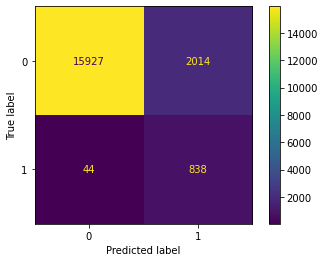

In [42]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf_classifier.classes_)
disp.plot()

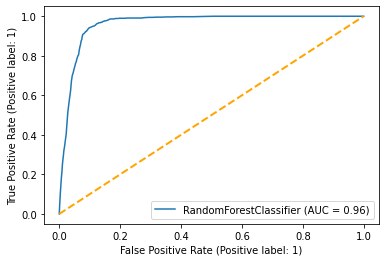

In [43]:
from sklearn.metrics import RocCurveDisplay
rfc_disp = RocCurveDisplay.from_estimator(rf_classifier, X_test, y_test)
plt.plot([0, 1], [0, 1], color='orange', lw=2, linestyle='--')

# Learning Technique #1: Sliding window with undersampling in training only

In [44]:
df.reset_index(drop=True, inplace=True)

In [45]:
# Specify the features (X) and the target variable (y)
X = df.drop(["timestamp", 
             "u", 
             "v", 
             "history_type", 
             "bip", 
             "cost", # cost of O1 features
             "history_size",
             "is_fraud",], axis="columns")
y = df["is_fraud"]

In [46]:
X

,number_of_nodes,degrees_nb_one,degrees_nb_two,degrees_min,degrees_max,degrees_median,weighted_degrees_nb_one,weighted_degrees_nb_two,weighted_degrees_min,weighted_degrees_max,weighted_degrees_median,u_degree,v_degree,u_same_degree,v_same_degree,u_greater_degree,v_greater_degree,u_weighted_degree,v_weighted_degree,u_same_weighted_degree,v_same_weighted_degree,u_greater_weighted_degree,v_greater_weighted_degree,number_of_links,total_weight,link_weights_nb_one,link_weights_nb_two,link_weights_min,link_weights_max,link_weights_median,u_v_weight,u_v_same_weight,u_v_greater_weight
0,43.0,26.0,14.0,1.0,9.0,1.0,24.0,13.0,1.0,10.0,1.0,1.0,6.0,26.0,1.0,17.0,1.0,1.0,6.0,24.0,1.0,19.0,1.0,36.0,40.0,34.0,1.0,1.0,4.0,1.0,1.0,34.0,2.0
1,44.0,27.0,14.0,1.0,9.0,1.0,25.0,13.0,1.0,10.0,1.0,1.0,7.0,27.0,1.0,17.0,1.0,1.0,7.0,25.0,1.0,19.0,1.0,37.0,41.0,35.0,1.0,1.0,4.0,1.0,1.0,35.0,2.0
2,44.0,26.0,15.0,1.0,10.0,1.0,24.0,14.0,1.0,11.0,1.0,2.0,10.0,15.0,1.0,3.0,0.0,2.0,11.0,14.0,1.0,6.0,0.0,38.0,42.0,36.0,1.0,1.0,4.0,1.0,1.0,36.0,2.0
3,46.0,28.0,15.0,1.0,10.0,1.0,26.0,14.0,1.0,11.0,1.0,1.0,1.0,28.0,28.0,18.0,18.0,1.0,1.0,26.0,26.0,20.0,20.0,39.0,43.0,37.0,1.0,1.0,4.0,1.0,1.0,37.0,2.0
4,47.0,29.0,14.0,1.0,10.0,1.0,27.0,13.0,1.0,11.0,1.0,1.0,3.0,29.0,2.0,18.0,2.0,1.0,3.0,27.0,3.0,20.0,4.0,40.0,44.0,38.0,1.0,1.0,4.0,1.0,1.0,38.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62738,110.0,86.0,17.0,1.0,24.0,1.0,65.0,11.0,1.0,24.0,1.0,1.0,24.0,86.0,1.0,24.0,0.0,1.0,24.0,65.0,1.0,45.0,0.0,84.0,144.0,57.0,14.0,1.0,9.0,1.0,1.0,57.0,27.0
62739,110.0,87.0,16.0,1.0,25.0,1.0,65.0,12.0,1.0,25.0,1.0,1.0,25.0,87.0,1.0,23.0,0.0,1.0,25.0,65.0,1.0,45.0,0.0,84.0,144.0,57.0,14.0,1.0,9.0,1.0,1.0,57.0,27.0
62740,111.0,88.0,16.0,1.0,26.0,1.0,66.0,12.0,1.0,26.0,1.0,1.0,26.0,88.0,1.0,23.0,0.0,1.0,26.0,66.0,1.0,45.0,0.0,85.0,145.0,58.0,14.0,1.0,9.0,1.0,1.0,58.0,27.0
62741,112.0,88.0,17.0,1.0,26.0,1.0,67.0,11.0,1.0,26.0,1.0,1.0,2.0,88.0,17.0,24.0,7.0,1.0,3.0,67.0,15.0,45.0,19.0,86.0,146.0,59.0,14.0,1.0,9.0,1.0,1.0,59.0,27.0


In [47]:
y

0        0
1        0
2        0
3        0
4        0
        ..
62738    0
62739    0
62740    0
62741    0
62742    0
Name: is_fraud, Length: 62743, dtype: int64

In [48]:
len(df) / 2

31371.5

In [49]:
8353+8350

16703

In [50]:
len(df)

62743

In [51]:
# Parameters we can change
window_delta = 100
delta = int(len(df) / window_delta)
print("Delta:", delta, "\n")

Delta: 627 



In [52]:
len(df)

62743

In [53]:
# Parameters we can change
window_delta = 100
delta = int(len(df) / window_delta)
print("Delta:", delta, "\n")

roc_auc_results = []
c = 1

# Start the sliding window with overlap
for i in range(0, int(len(df) / 2), delta):
    b_i = i
    e_i = i + int(len(df) / 2)

    X_subset = X.iloc[b_i:e_i]
    y_subset = y.iloc[b_i:e_i]
    print(X_subset.index)

    X_train, X_test, y_train, y_test = train_test_split(X_subset, y_subset, test_size=0.2, shuffle=False)

    # Undersample the majority class (0) within each window
    X_train_sampled = pd.concat([X_train[y_train == 0].sample(n=sum(y_train == 1), random_state=12), X_train[y_train == 1]])
    y_train_sampled = pd.concat([y_train[y_train == 0].sample(n=sum(y_train == 1), random_state=12), y_train[y_train == 1]])

    # Compute counts of y = 1 and y = 0 for y_train
    y_train_1_count = sum(y_train_sampled == 1)
    y_train_0_count = sum(y_train_sampled == 0)
    
    # Compute counts of y = 1 and y = 0 for y_test
    y_test_1_count = sum(y_test == 1)
    y_test_0_count = sum(y_test == 0)
    
    print(f"Iteration {c}:")
    print(f"Counts of y = 1 and y = 0 in y_train: {y_train_1_count}, {y_train_0_count}")
    print(f"Counts of y = 1 and y = 0 in y_test: {y_test_1_count}, {y_test_0_count}")
    c += 1
    
    clf = RandomForestClassifier(random_state=42)
    clf.fit(X_train_sampled, y_train_sampled)
    y_pred = clf.predict(X_test)
    
    roc_auc = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])

    roc_auc_results.append(roc_auc)
    print(b_i)
    print(f"Iteration difference {e_i - b_i}: ROC-AUC={roc_auc:.4f}")
    print("------------------------------------------------------------------------------------------------")

average_roc_auc = sum(roc_auc_results) / len(roc_auc_results)

print(f"Average ROC-AUC: {average_roc_auc:.4f}")


Delta: 627 

RangeIndex(start=0, stop=31371, step=1)
Iteration 1:
Counts of y = 1 and y = 0 in y_train: 1198, 1198
Counts of y = 1 and y = 0 in y_test: 324, 5951
0
Iteration difference 31371: ROC-AUC=0.9805
------------------------------------------------------------------------------------------------
RangeIndex(start=627, stop=31998, step=1)
Iteration 2:
Counts of y = 1 and y = 0 in y_train: 1204, 1204
Counts of y = 1 and y = 0 in y_test: 324, 5951
627
Iteration difference 31371: ROC-AUC=0.9774
------------------------------------------------------------------------------------------------
RangeIndex(start=1254, stop=32625, step=1)
Iteration 3:
Counts of y = 1 and y = 0 in y_train: 1209, 1209
Counts of y = 1 and y = 0 in y_test: 314, 5961
1254
Iteration difference 31371: ROC-AUC=0.9790
------------------------------------------------------------------------------------------------
RangeIndex(start=1881, stop=33252, step=1)
Iteration 4:
Counts of y = 1 and y = 0 in y_train: 1212, 1212

16929
Iteration difference 31371: ROC-AUC=0.9347
------------------------------------------------------------------------------------------------
RangeIndex(start=17556, stop=48927, step=1)
Iteration 29:
Counts of y = 1 and y = 0 in y_train: 1217, 1217
Counts of y = 1 and y = 0 in y_test: 304, 5971
17556
Iteration difference 31371: ROC-AUC=0.9327
------------------------------------------------------------------------------------------------
RangeIndex(start=18183, stop=49554, step=1)
Iteration 30:
Counts of y = 1 and y = 0 in y_train: 1218, 1218
Counts of y = 1 and y = 0 in y_test: 301, 5974
18183
Iteration difference 31371: ROC-AUC=0.8888
------------------------------------------------------------------------------------------------
RangeIndex(start=18810, stop=50181, step=1)
Iteration 31:
Counts of y = 1 and y = 0 in y_train: 1223, 1223
Counts of y = 1 and y = 0 in y_test: 303, 5972
18810
Iteration difference 31371: ROC-AUC=0.9366
---------------------------------------------------

In [54]:
df.tail(2)

,timestamp,u,v,is_fraud,history_type,history_size,bip,cost,number_of_nodes,degrees_nb_one,degrees_nb_two,degrees_min,degrees_max,degrees_median,weighted_degrees_nb_one,weighted_degrees_nb_two,weighted_degrees_min,weighted_degrees_max,weighted_degrees_median,u_degree,v_degree,u_same_degree,v_same_degree,u_greater_degree,v_greater_degree,u_weighted_degree,v_weighted_degree,u_same_weighted_degree,v_same_weighted_degree,u_greater_weighted_degree,v_greater_weighted_degree,number_of_links,total_weight,link_weights_nb_one,link_weights_nb_two,link_weights_min,link_weights_max,link_weights_median,u_v_weight,u_v_same_weight,u_v_greater_weight
62741,1098744711,1624,1878,0,G,518400,False,0.0,112.0,88.0,17.0,1.0,26.0,1.0,67.0,11.0,1.0,26.0,1.0,1.0,2.0,88.0,17.0,24.0,7.0,1.0,3.0,67.0,15.0,45.0,19.0,86.0,146.0,59.0,14.0,1.0,9.0,1.0,1.0,59.0,27.0
62742,1098744742,1624,1878,0,G,518400,False,0.0,112.0,88.0,17.0,1.0,26.0,1.0,66.0,12.0,1.0,26.0,1.0,1.0,2.0,88.0,17.0,24.0,7.0,2.0,4.0,12.0,5.0,34.0,15.0,86.0,147.0,58.0,15.0,1.0,9.0,1.0,2.0,15.0,13.0


In [55]:
# Create a DataFrame
df2 = pd.DataFrame({"Values": roc_auc_results})

# Export DataFrame to Excel
df2.to_excel("UCIMessages-5Perc-G518400-AUCInSlidingWindow.xlsx", index=False)

In [56]:
len(roc_auc_results)

51

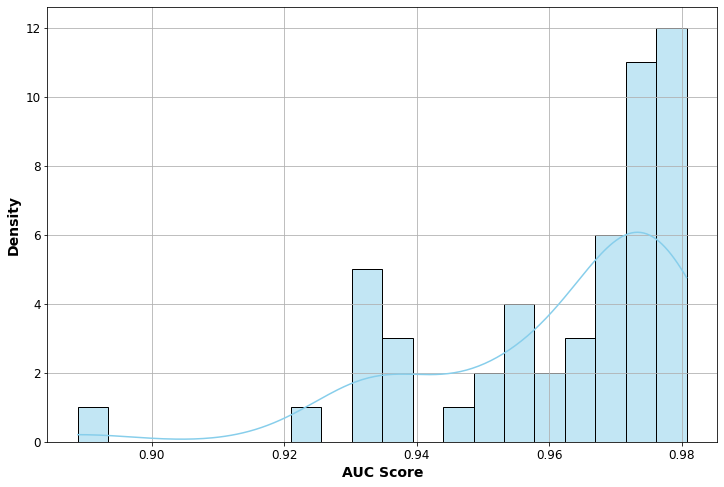

In [57]:
import seaborn as sns

# Plot the distribution with kernel density estimate
plt.figure(figsize=(12, 8))
sns.histplot(df2["Values"], kde=True, bins=20, color='skyblue')
plt.xlabel("AUC Score", fontsize=14,  fontweight='bold')
plt.ylabel("Density", fontsize=14,  fontweight='bold')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True)
plt.show()